In [10]:
"""
Short script to simulate the MFCS unit in room g015 at the university of applied sciences in mannheim. First, values are simulated that are based on a true historical yeast experiment. Then a noise is added to the simulated values and at the end the data is uploaded as the MFCS unit in g015 would do.

"""


#imports

#sys.path.append(import_path)       #to get modules from another directory, sys.path.append("..") to get module from directory above
from biomoni.Experiment import Experiment
from biomoni.Yeast import Yeast
from biomoni.visualize import visualize

from settings_opcua import units_id, variables_id, values_id, url, sample_interval
import numpy as np
from scipy import integrate
from opcua import Server
import time
from datetime import datetime
from lmfit import Parameters
from param_collection import p0
%load_ext autoreload
%autoreload 2

#import path


#Linux path:
path = "/home/paul/pCloudDrive/Code/Messdaten"


#windows path:
#path = r"P:\Code\Messdaten"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

##Simulate an Experiment by using the metadata from an real Experiment - F7 in thise case
Exp = Experiment(path, "F7")  #load experiment 7
y = Yeast()
t_grid = np.linspace(0,8, 8*60)     #8 h measureing time, every minute 1 measurement point
y.set_params(p0) #set params to params in settings#simulate with experimental data, params from settings_mimic and selected number of steps
sim = y.simulate(Exp, t_grid = t_grid)     #507 steps for 8.45 hours in exp 7 means 1 step per minute
sim["BASET"] = integrate.cumtrapz(sim["BASET_rate"], x= sim.index, initial = 0) #integrate base rate to get cumulative base signal



##add random noise array to simulated data 
# noise = np.random.normal(0, 0.02, np.shape(sim)) # noise with expected value:0 STDDEV:0.03, same shape as simulated data
# sim = sim * (1+ noise)

visualize(sim)

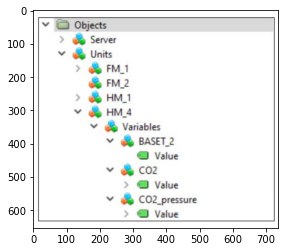

In [12]:
#Create an object of the class Server
server = Server()
#Set up the Host name and the port number at which the server will be running

url = url
server.set_endpoint(url)

#Create a namespace of the server. It takes the name as an argument
#AdressSpace is the place where all the set of objects and related information are stored
addspace=server.register_namespace("MFCS_Server_mimic")

#create objects
objects = server.get_objects_node()     #returns a node object
Units =objects.add_object('ns=2;s="Units"', "Units")    #Units correspond to the four bioreactors: Herr Menta and Frau Menta each control wo bioreactors
FM_1= Units.add_object(*units_id["FM_1"])
FM_2= Units.add_object(*units_id["FM_2"])
HM_3= Units.add_object(*units_id["HM_3"])
HM_4= Units.add_object(*units_id["HM_4"])

#add variables category object to just Herr Menta 4
Variables = HM_4.add_object('ns=2;s="Variables"', "Variables")

#add different variable objects to Variables category
BASET = Variables.add_object(*variables_id["BASET"])
CO2 = Variables.add_object(*variables_id["CO2"])
CO2_p = Variables.add_object(*variables_id["CO2_pressure"])
PDatTime = Variables.add_object(*variables_id["ts"])


#add values to the variables
Value_BASET = BASET.add_variable(*values_id["BASET"])        #default value is zero: gets changed anyway
Value_CO2 = CO2.add_variable(*values_id["CO2"])
Value_CO2_p = CO2_p.add_variable(*values_id["CO2_pressure"])
Value_PDatTime = PDatTime.add_variable(*values_id["ts"])


# This is how the server is build up 
# Show structure of MFCS Server
import matplotlib.image as image
import matplotlib.pyplot as plt

img = image.imread('MFCS_scheme.png')
plt.imshow(img)



In [13]:
try:
    print("Start Server")
    server.start()

    i = 0
    while True:
        
        if i > len(sim) -1:
            print("Process finished, last index reached")
            break
        ts = datetime.now().strftime("%d.%m.%Y  %H:%M:%S")     #date time now as string with specified format corresponding to PDatTime format in MFCS

        Value_BASET.set_value(sim["BASET"].iloc[i])
        Value_CO2.set_value(sim["CO2"].iloc[i])
        Value_PDatTime.set_value(ts)

        #just in case you want to make CO2 also random
        Value_CO2_p.set_value(1.058)
        noise_pressure = np.random.normal(0, 0.03)
        Value_CO2_p.set_value(Value_CO2_p.get_value()  * (1+ noise_pressure))
        
        print(Value_PDatTime.get_value(), Value_BASET.get_value(), Value_CO2.get_value(),  Value_CO2_p.get_value())
        
        i += 1
        time.sleep(sample_interval)


finally:
    server.stop()
    print("Server offline")

Endpoints other than open requested but private key and certificate are not set.
Listening on 127.0.0.1:4848


Start Server
21.12.2021  15:45:55 0.0 1.2677242172960825 1.0411824490064279
21.12.2021  15:46:55 0.006663971629301545 1.2726810978857765 1.013102183571904
21.12.2021  15:47:55 0.013359003341641536 1.2775854626111198 1.053723566350438
21.12.2021  15:48:55 0.020085123500290743 1.2824309338067093 1.085229368389373
21.12.2021  15:49:55 0.026842350614751626 1.2872104563611133 1.058965074147963
21.12.2021  15:50:55 0.033630692203582 1.2919162156730792 1.0528732957797142
21.12.2021  15:51:55 0.04045014359480603 1.2965395326315514 1.031404485085724
21.12.2021  15:52:55 0.0473006865192241 1.3010707441338174 1.0922008841538589
21.12.2021  15:53:56 0.05418228755339691 1.3054990562998516 1.0884075320858135
21.12.2021  15:54:56 0.06109489631803461 1.3098123827297417 1.0676839654719397
21.12.2021  15:55:56 0.0680384432438094 1.3139971722525072 1.0779131904131434
21.12.2021  15:56:56 0.0750128370907673 1.3180381691263248 1.0719999981075838
21.12.2021  15:57:56 0.08201796222413373 1.3219181341747557 1